In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from scipy.stats import pearsonr
from helper_functions import add_xmonth_default_flag, classification_power
import warnings

plt.style.use('ggplot')

In [84]:
# Need to run felix_hoschle_data_cleaning.ipynb first to obtain cleaned data sets
mo_df = pd.read_csv("./data/monthly_outcome_cleaned.csv")
ap_df = pd.read_csv("./data/application_cleaned.csv")

## Task 1.2: another target
QUESTION: In order to understand the performance of a model before it's too late, we also want to monitor the repayment behaviours after the first few repayments. 

Could you please create another "early-risk" target *is_bad_3m* which represents whether the customers ever had **2 or more** repayments in arrear at any point of their first three scheduled ones?



FELIX: I added this task to the main notebook as I felt its a better fit. The code for the function is in helper_function.py as I already used the same function to replace missing is_bad_12m values.

In [85]:
warnings.filterwarnings("ignore")

# reuse function created when removing Nulls for 12m bad flag
ap_df = add_xmonth_default_flag(ap_df, mo_df, 3, col_suffix='')

# Compare to 12m, there need to be strictly fewer defaults in 3m than in 12m
print(len(ap_df.query('is_bad_3m==1 & is_bad_12m==0')))

0


# Part 2. Model validation



## Task 2.1: classification power

QUESTION: A common metric used in the credit risk modelling world is the Gini coefficient, which can be linearly mapped to ROCAUC if that's a term you are more familiar with. Could you please compare the Gini's between the two models as a first step? 




An extended question: assuming that classification power is all we care about, what are the other reasons to not pick the model with highest Gini? It's enough to just write down your thoughts. 

FELIX: The ROC curve tells us about the FPR and FNR for every threshold. The GINI coefficient tells us the area under the curve.<br>
However, while one model might be better in terms of the complete area, it is possible that locally the model with the interior GINI coefficient is preferable.<br>
<br>
I will use the monitoring sample wherever possible for model evaluation. Below is a graph confirming the size of development/monitoring/post-deployment sample size.

Text(0.5, 1.0, 'Number of applications by origination date')

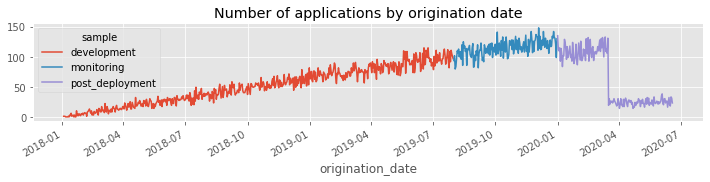

In [86]:
# Split sample into development, monitoring and post deployment and sense check the outcome in a plot
ap_df['origination_date'] = pd.to_datetime(ap_df['origination_date'])


ap_df['sample'] = np.where(ap_df['origination_date'] < pd.to_datetime("2019-08-01"), 'development',
                           np.where(ap_df['origination_date'] < pd.to_datetime("2020-01-01"), 'monitoring', 
                           'post_deployment'))

ap_df.groupby(['sample', 'origination_date']).size().unstack('sample').plot(figsize=(12,2))
plt.title("Number of applications by origination date")

FELIX: Model 1 has a higher AUC and basically all thresholds. It also has a superior recall curve. However, at some thresholds model 2 has a higher precision.

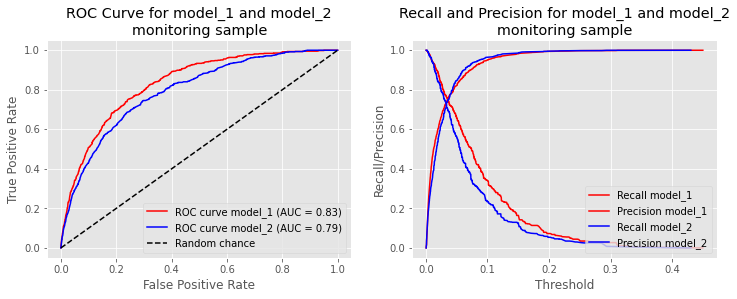

In [87]:
# Validate models based on monitoring sample
ap_df_monitoring = ap_df.query('sample=="monitoring"')

auc_score_m1, fpr_m1, tpr_m1, thresholds_m1, _, _ = classification_power(ap_df_monitoring, 'is_bad_12m', 'model_1')
auc_score_m2, fpr_m2, tpr_m2, thresholds_m2, _, _ = classification_power(ap_df_monitoring, 'is_bad_12m', 'model_2')

# Plot ROC curve and Precision-Recall curve for each model
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(fpr_m1, tpr_m1, label=f'ROC curve model_1 (AUC = {auc_score_m1:.2f})', color='red')
plt.plot(fpr_m2, tpr_m2, label=f'ROC curve model_2 (AUC = {auc_score_m2:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for model_1 and model_2\nmonitoring sample')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(thresholds_m1, tpr_m1, label=f'Recall model_1', color='red')
plt.plot(thresholds_m1, 1-fpr_m1, label=f'Precision model_1', color='red')
plt.plot(thresholds_m2, tpr_m2, label=f'Recall model_2', color='blue')
plt.plot(thresholds_m2, 1-fpr_m2, label=f'Precision model_2', color='blue')
plt.xlabel('Threshold')
plt.ylabel('Recall/Precision')
plt.title('Recall and Precision for model_1 and model_2\nmonitoring sample')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Task 2.2: classification power in segments

QUESTION: As the population of future business might have different distributions from the development sample, we would ideally want the chosen model to be performant in all segments. For simplicity let's stick with univariate segments only.

Could you please compare the Gini's between the two models in the segments of all the variables? Feel free to define the segments as you see appropriate. 


FELIX:<br>
There is many ways of splitting the variables. <br>
It might be desirable to split a variable so that an equal portion of TPs is in each group. <br>
There also might be business reason to split a variable along a specific threshold<br>
<br>
For simplicity, I split the variables along their medians. This will ensure equal sample size for each segment.<br>
<br>
I neglect here to check if each segment still includes some of the sparse TPs.<br>
<br>
Result: Model 1 outperforms Model 2 in terms of AUC for each segment that I have created

In [88]:
# Create splits for each relevant feature
relevant_features_for_split = ['loan_term', 'loan_amount',
                              'age_oldest_account', 'total_value_of_mortgage', 
                              'current_utilisation', 'months_since_2_payments_missed', 
                              'number_of_credit_searches_last_3_months']

for feature in relevant_features_for_split:
    ap_df_monitoring[f'{feature}_split'] = np.where(ap_df_monitoring[feature] > ap_df_monitoring[feature].median(), 'high', 'low')


Text(0.5, 1.0, 'AUC for model_1 and model_2 in different segments\nmonitoring sample')

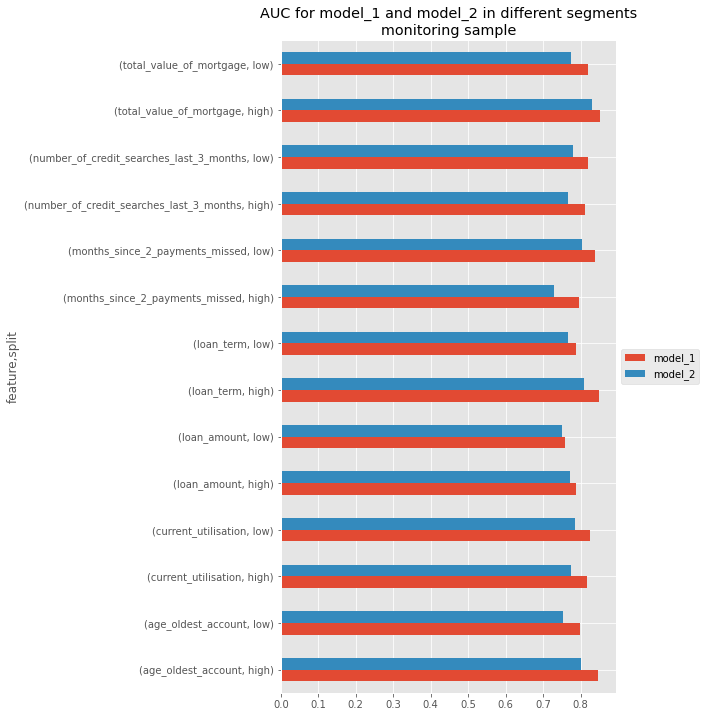

In [89]:
# Calculate AUC for each segment and model
rows = []
for feature in relevant_features_for_split:
    for split in ['high', 'low']:
        for model in ['model_1', 'model_2']:
            auc_score, _, _, _, sample_size, bad_rate = classification_power(ap_df_monitoring.query(f'{feature}_split==@split'), 'is_bad_12m', model)
            rows.append([feature, split, model, auc_score])


# Create a dataframe from the rows
model_performance_segmented = pd.DataFrame(rows, columns=['feature', 'split', 'model', 'auc'])
model_performance_segmented = model_performance_segmented.pivot_table(index=['feature', 'split'], columns='model', values='auc')


# Plot results -> Model 1 performs better in all segments w.r.t to AUC
model_performance_segmented.plot(kind='barh', figsize=(6, 12))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('AUC for model_1 and model_2 in different segments\nmonitoring sample')

## Task 2.3: accuracy 
QUESTION: As we want to use our model for loss estimates and pricing of each customer, could you please check whether the scores (as probabilistic predictions) are accurate with respect to the actual "bad rates" (i.e. the fraction of *is_bad_12m*=1 among customers of similar scores)


FELIX:<br>
I am splitting the monitoring data into 10 equally large parts based on model 1 deciles.<br>
I then compare the predicted 12m bad rate to the actual bad rate <br>
While the absolute difference between the bad rates increases for higher model 1 scores, the relative difference remains fairly stable.<br>
Thus, the model seems reasonable for all model_1 score deciles.

Text(0.5, 1.0, 'Relative difference between\nactual and predicted bad rate\n monitoring sample')

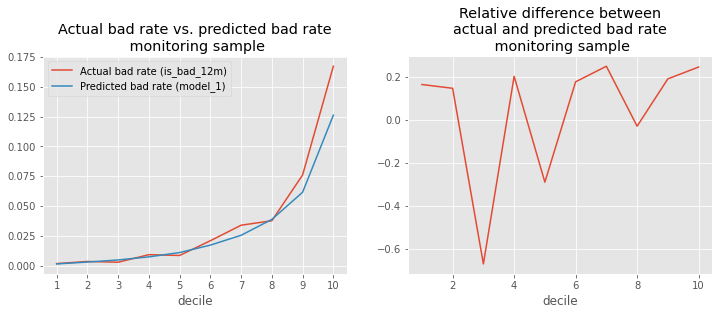

In [90]:
# split ap_df_monitoring into 10 equal portions based on model_1 score
ap_df_monitoring['decile'] = pd.qcut(ap_df_monitoring['model_1'], 10, labels=False) + 1
ap_df_monitoring.groupby('decile').size()
# For each decile and calculate the bad rate based on is_bad_12m and the average model_1 score
bad_rate_per_decile = ap_df_monitoring.groupby('decile').agg({'is_bad_12m':'mean', 'model_1':'mean'})

# Put those plots next to each other in a subplot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
bad_rate_per_decile['is_bad_12m'].plot()
bad_rate_per_decile['model_1'].plot()
plt.legend(['Actual bad rate (is_bad_12m)', 'Predicted bad rate (model_1)'])
t = plt.xticks(range(1, 11))
plt.title('Actual bad rate vs. predicted bad rate\n monitoring sample')

plt.subplot(1, 2, 2)
((bad_rate_per_decile['is_bad_12m'] - bad_rate_per_decile['model_1'])/bad_rate_per_decile['is_bad_12m']).plot()
plt.title('Relative difference between\nactual and predicted bad rate\n monitoring sample')


## Task 2.4: calibration

QUESTION: We also want to monitor the early risk indicator *is_bad_3m* in case something really bad happens (e.g. a pandemic). For that we need to calibrate our scores to the probability of such short-term outcome. Could you please create the calibrated scores for the two models and validate them? (Hint: if this is not a topic you are familiar with, scikit-learn has some handy utilities)

FELIX: <br>
I am not sure if I am doing this right, but I will fit a model with is_bad_3m as the target and model_1 and model_2 scores as the features.<br>
The idea is, that since is_bad_3m depends on similar features than is_bad_12m, the model scores should hold predictive power.<br>
Indeed, it appears that the AUC for the resulting model is very similar to the AUC of model_1 w.r.t to the is_bad_12m target.

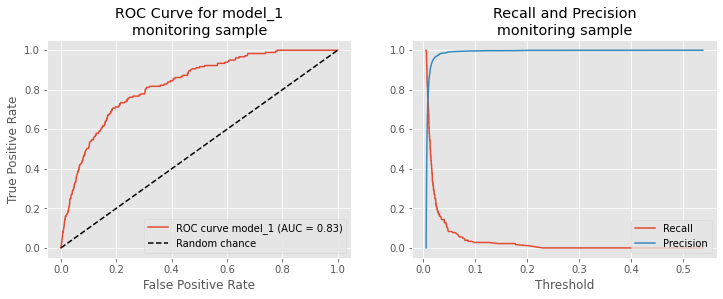

In [91]:
# Not sure if I am doing this right, but I woud just predict is_bad_3m based on the model_1 and model_2 scores

ap_df_development = ap_df.query('sample=="development"')
ap_df_monitoring = ap_df.query('sample=="monitoring"')
ap_df_post_deployment = ap_df.query('sample=="post_deployment"')

# Run logistic regression on model_1 and model_2 with is_bad_3m as target
# Results: Model 1 is better than model 2
X_train = ap_df_development[['model_1', 'model_2']]
y_train = ap_df_development['is_bad_3m']

X_test = ap_df_monitoring[['model_1', 'model_2']]
y_test = ap_df_monitoring['is_bad_3m']

lr = LogisticRegression()
lr.fit(X_train, y_train)

ap_df_monitoring['is_bad_3m_pred'] = lr.predict_proba(X_test)[:, 1]

# RoC curve of new model
auc_score, fpr, tpr, thresholds, _, _ = classification_power(df=ap_df_monitoring, target='is_bad_3m', score='is_bad_3m_pred')


# Plot RoC curve and Recall/Precision
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve model_1 (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curve for model_1\nmonitoring sample')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(thresholds, tpr, label=f'Recall')
plt.plot(thresholds, 1-fpr, label=f'Precision')
plt.xlabel('Threshold')
plt.legend(loc='lower right')
plt.grid(True)
plt.title('Recall and Precision\nmonitoring sample')
plt.show()

# Part 3. Model monitoring

## Task 3.1: model performance

QUESTION: How did the model perform in this monitoring sample, before & after its deployment into production? How does that compare to the expectation from the development sample? 

FELIX: <br>
The model is performing significantly worse in the post deployment period.<br>
Precision and recall are compareable for deployment and monitoring set. However, recall drops from 65% to 8% post deployment.<br>
This means, the model is massively afailing to predict bad loands in the post deployment period.

In [92]:
# Validation for development, monitoring and post deployment
ap_df_development = ap_df.query('sample=="development"')
ap_df_monitoring = ap_df.query('sample=="monitoring"')
ap_df_post_deployment = ap_df.query('sample=="post_deployment"')

auc_score_dev, fpr_dev, tpr_dev, thresholds_dev, _, _ = classification_power(ap_df_development, 'is_bad_12m', 'model_1')
auc_score_mon, fpr_mon, tpr_mon, thresholds_mon, _, _ = classification_power(ap_df_monitoring, 'is_bad_12m', 'model_1')
auc_score_post, fpr_post, tpr_post, thresholds_post, _, _ = classification_power(ap_df_post_deployment, 'is_bad_12m', 'model_1')

# Calculate precision and recall for threshold<0.05
# Do it for development, monitoring and post deployment
threshold = 0.05
ap_df_development['prediction'] = np.where(ap_df_development['model_1'] > threshold, 1, 0)
ap_df_monitoring['prediction'] = np.where(ap_df_monitoring['model_1'] > threshold, 1, 0)
ap_df_post_deployment['prediction'] = np.where(ap_df_post_deployment['model_1'] > threshold, 1, 0)

# Calculate precision and recall for columns is_bad_12m and prediction
precision_dev = ap_df_development.query('prediction==1')['is_bad_12m'].mean()
recall_dev = ap_df_development.query('is_bad_12m==1')['prediction'].mean()
# same for monitoring
precision_mon = ap_df_monitoring.query('prediction==1')['is_bad_12m'].mean()
recall_mon = ap_df_monitoring.query('is_bad_12m==1')['prediction'].mean()
# same for post deployment
precision_post = ap_df_post_deployment.query('prediction==1')['is_bad_12m'].mean()
recall_post = ap_df_post_deployment.query('is_bad_12m==1')['prediction'].mean()
# Create table with results
res = pd.DataFrame({'precision':[precision_dev, precision_mon, precision_post], 
              'recall':[recall_dev, recall_mon, recall_post]}, 
              index=['development', 'monitoring', 'post deployment'])
# print the results
print(res)


                 precision    recall
development       0.122034  0.651184
monitoring        0.121247  0.657188
post deployment   0.083333  0.010309


## Task 3.2: why the changes?

QUESTION: If you observe a difference, what do you think can be the reason(s)? How are you going to verify your hypothesis?

FELIX:<br>
Since the model performance is similar between the development and monitoring period, this seems not to be a case of classic over  to the training data. <br>
As the graph below shows, the post deployment period sees a significant increase in the bad loan rate. I have 3 hypothesis of why this is happening:<br>
1. **Covid**: The bad rate increases about 1 year after the initial lookdown in the UK. This might be just enough time for customers to start defaulting.<br>
        This hypothesis could be supstantiated by checking if the defaulting customers tend to work in covid impacted industries (e.g. travel, entertainment)<br>
2. **Loan approval threshold**: If the threshold at which loans are approved had been lowered, customers would come into the dataset for whom the model has not been optimized. The model could then be validated against customers with lower thresholds only.<br>
3. **Customers learning to game the system**: Customers might have learned to tick the right boxes when applying for a loan. This could lead to changing data patterns that the model is not optimized for.<br>

Text(2020-03-10 00:00:00, 0.05, 'First UK\ncovid lookdown')

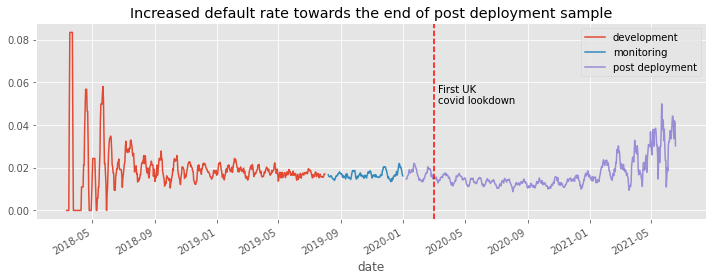

In [93]:
mo_df['date'] = pd.to_datetime(mo_df['date'])
mo_df['sample'] = np.where(mo_df['date'] < pd.to_datetime("2019-08-01"), 'development',
                           np.where(mo_df['date'] < pd.to_datetime("2020-01-01"), 'monitoring', 
                           'post_deployment'))

mo_df_agg = mo_df.groupby(['sample', 'date']) \
                 .agg({'status_delta_previous_period':'mean'}) \
                 .unstack('sample') \
                 .sort_index(ascending=True) \
                 .rolling(window=7)\
                 .mean()

mo_df_agg.plot(figsize=(12,4))
plt.legend(['development', 'monitoring', 'post deployment'])
plt.title('Increased default rate towards the end of post deployment sample')
plt.axvline(pd.to_datetime("2020-03-01"), color='red', linestyle='--')
plt.text(pd.to_datetime("2020-03-10"), 0.05, 'First UK\ncovid lookdown')

## Task 3.3: new variable

QUESTION: You might have noticed that a new variable ***stress_score*** has become available since late 2019. Can you figure out whether there is additional classification power from this variable over our models? 

If so, how would you incorporate it into our decision model?


FELIX:<br>
We are starting by confirming that the stress_score seperates good and bad loans.<br>
That is to say that the distributions of the stress_score are different for good and bad loans.<br>
The graph below supports this both in monitoring and post deployment.<br>

Text(0.5, 1.0, 'Post deployment')

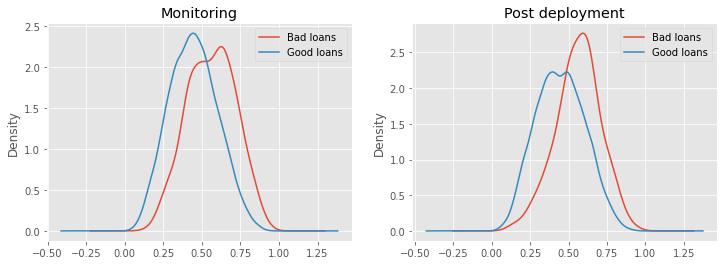

In [94]:
# density function for stress_score split by is_bad_12m, stress_score not available for development period
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

ap_df_monitoring.query('is_bad_12m==1')['stress_score'].plot(kind='kde')
ap_df_monitoring.query('is_bad_12m==0')['stress_score'].plot(kind='kde')
plt.legend(['Bad loans', 'Good loans'])
plt.title('Monitoring')

plt.subplot(1, 2, 2)
ap_df_post_deployment.query('is_bad_12m==1')['stress_score'].plot(kind='kde')
ap_df_post_deployment.query('is_bad_12m==0')['stress_score'].plot(kind='kde')
plt.legend(['Bad loans', 'Good loans'])
plt.title('Post deployment')



FELIX:<br>
However, creating separation is not enough. The new variable also needs to be not too correlated with the existing features to contain additional predictive power.<br>
This also seems to be the case here, as there is only a weak correlation between model_1 scores and the new variable.

In [95]:
# The stress_score variable is somewhat correlated with model_1, however, the correlation is week enough that there still might be predictive power in stress_score
ap_df_monitoring_dropna = ap_df_monitoring.dropna(subset=['stress_score'])
ap_df_post_deployment_dropna = ap_df_post_deployment.dropna(subset=['stress_score'])

# Low, but significant correlation, so we would still expect additional predictive power from stress_score
correlation, p_value = pearsonr(ap_df_monitoring_dropna['stress_score'], ap_df_monitoring_dropna['model_1'])
print(f'Correlation between stress_score and model_1: {correlation:.4f} (p-value: {p_value:.4f})')

# even less of a correlation which would be good for predictive power
correlation, p_value = pearsonr(ap_df_post_deployment_dropna['stress_score'], ap_df_post_deployment_dropna['model_1'])
print(f'Correlation between stress_score and model_1: {correlation:.4f} (p-value: {p_value:.4f})')

Correlation between stress_score and model_1: 0.0454 (p-value: 0.0000)
Correlation between stress_score and model_1: 0.0019 (p-value: 0.8446)


FELIX:<br>
To prove the predictive power of stress_score, we will fit a logistic regression model with model_1 and stress_score as input variables and is_bad_12m as target. <br>
If stress_score is predictive, we would expect the AUC to increase to increase compared to model_1. <br>
We would also expect the precision and recall to increase at the chosen threshold of 0.05. <br>
Other models like Random Forest or Gradient Boosting could be used as well and mount lead to even stronger uplifts. <br>
<br>
Results: <br>
Adding stress_score as feature in an logistic regression improves AUC slightly and yields a higher RoC curve at most thresholds.<br>
At the predefined threshold, precision is slightly lower for the LR model, but recall is significantly higher.<br>
We can conclude that adding stress_score leads to significant model improvements, especially at our chosen threshold.



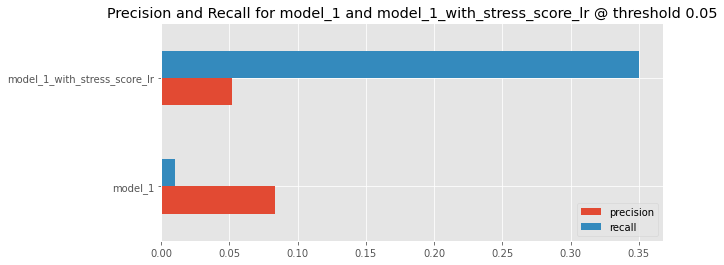

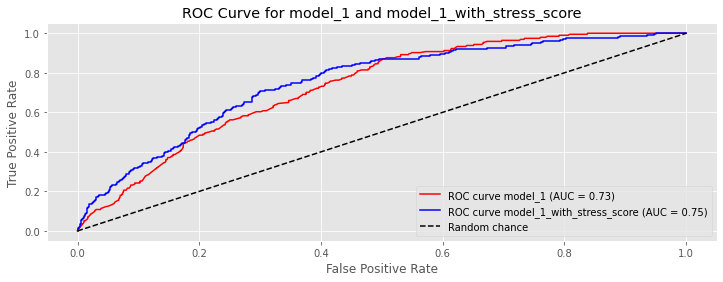

In [96]:

imputer = SimpleImputer(strategy='mean')

X_train = ap_df_monitoring[['model_1', 'stress_score']]
X_train = imputer.fit_transform(X_train)
y_train = ap_df_monitoring['is_bad_12m']

X_test = ap_df_post_deployment[['model_1', 'stress_score']]
X_test = imputer.transform(X_test)
y_test = ap_df_post_deployment['is_bad_12m']


# fit logistic regression model
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# predict
ap_df_post_deployment['model_1_with_stress_score_lr'] = lr.predict_proba(X_test)[:, 1]

# RoC curve for model_1 and model_1_with_stress_score_lr
auc_score_m1s_lr, fpr_m1s_lr, tpr_m1s_lr, thresholds_m1s_lr, _, _ = classification_power(df=ap_df_post_deployment, target='is_bad_12m', score='model_1_with_stress_score_lr')
auc_score_m1, fpr_m1, tpr_m1, thresholds_m1, _, _ = classification_power(df=ap_df_post_deployment, target='is_bad_12m', score='model_1')

# Precision & Recall for model_1 and model_1_with_stress_score_lr @ threshold 0.05
threshold = 0.05
ap_df_post_deployment['prediction_lr'] = np.where(ap_df_post_deployment['model_1_with_stress_score_lr'] > threshold, 1, 0)
ap_df_post_deployment['prediction'] = np.where(ap_df_post_deployment['model_1'] > threshold, 1, 0)

precision_lr = ap_df_post_deployment.query('prediction_lr==1')['is_bad_12m'].mean()
recall_lr = ap_df_post_deployment.query('is_bad_12m==1')['prediction_lr'].mean()

precision = ap_df_post_deployment.query('prediction==1')['is_bad_12m'].mean()
recall = ap_df_post_deployment.query('is_bad_12m==1')['prediction'].mean()

# Create table with results
res = pd.DataFrame({'precision':[precision, precision_lr], 
              'recall':[recall, recall_lr]}, 
              index=['model_1', 'model_1_with_stress_score_lr']).T

# plot
res.T.plot(kind='barh', figsize=(9, 4))
plt.title('Precision and Recall for model_1 and model_1_with_stress_score_lr @ threshold 0.05')

# plot RoC curve for both models
plt.figure(figsize=(12, 4))
plt.plot(fpr_m1, tpr_m1, label=f'ROC curve model_1 (AUC = {auc_score_m1:.2f})', color='red')
plt.plot(fpr_m1s_lr, tpr_m1s_lr, label=f'ROC curve model_1_with_stress_score (AUC = {auc_score_m1s_lr:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for model_1 and model_1_with_stress_score')
plt.legend(loc='lower right')

